# State Prediction with Transformer

- Approach: we will use a standard encodder transformer model to predict the next state of the flight

- Initially we have state vectors for every second -> we can resample to 3 or 5 interval seconds to ease computation



In [1]:
# first we load in the necessary libraries
import pandas as pd 
import glob 
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
# ML - scikit-learn and pytorch libraries
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Loading in the flight state vector paths (using the accident for now as querying a sample of normal flights atm)

In [2]:
# glob is useful here for loading in all the flight state vector paths into a list
flight_state_vectors_paths = glob.glob("../../data/raw/accident_flight_states/*")
flight_state_vectors_paths_2 = glob.glob("../../data/raw/normal_flight_states/*")

# look at first 10 flight state vector paths
print("Accident flight paths:")
print(flight_state_vectors_paths[:10])
print("\nNormal flight paths:") 
print(flight_state_vectors_paths_2[:10])

Accident flight paths:
['../../data/raw/accident_flight_states/state_vectors_a52acc_1654088894_1654111587.parquet', '../../data/raw/accident_flight_states/state_vectors_a255d9_1588773983_1588801421.parquet', '../../data/raw/accident_flight_states/state_vectors_a7e3cb_1580225813_1580235289.parquet', '../../data/raw/accident_flight_states/state_vectors_a88cbf_1616951147_1616955197.parquet', '../../data/raw/accident_flight_states/state_vectors_a052d4_1727960352_1727965975.parquet', '../../data/raw/accident_flight_states/state_vectors_a81344_1657884224_1657890629.parquet', '../../data/raw/accident_flight_states/state_vectors_a6bac5_1697919371_1697934368.parquet', '../../data/raw/accident_flight_states/state_vectors_4ca9cb_1693357437_1693378258.parquet', '../../data/raw/accident_flight_states/state_vectors_a0907b_1591456482_1591457426.parquet', '../../data/raw/accident_flight_states/state_vectors_a18899_1675518416_1675524470.parquet']

Normal flight paths:
['../../data/raw/normal_flight_sta

## Data Preprocessing - Setting up the data

- We can resample and impute -> reduce and clean 

In [3]:
# Diagnostic prints
print("=== Checking first file from each path ===")

# Check first file from flight_state_vectors_paths
print("\nFirst accident flight file:")
df1 = pd.read_parquet(flight_state_vectors_paths[0])
print("Columns:", df1.columns.tolist())

# Check first file from flight_state_vectors_paths_2
print("\nFirst normal flight file:")
df2 = pd.read_parquet(flight_state_vectors_paths_2[0])
print("Columns:", df2.columns.tolist())

# Check if the column names might be different (case sensitivity, spacing, etc)
print("\nDetailed column comparison:")
print("Accident flight columns:", [f"'{col}'" for col in df1.columns])
print("Normal flight columns:", [f"'{col}'" for col in df2.columns])

=== Checking first file from each path ===

First accident flight file:
Columns: ['icao24', 'time', 'lat', 'lon', 'velocity', 'heading', 'vertrate', 'callsign', 'onground', 'spi', 'squawk', 'geoaltitude', 'baroaltitude']

First normal flight file:
Columns: ['icao24', 'time', 'lat', 'lon', 'velocity', 'heading', 'vertrate', 'callsign', 'onground', 'spi', 'squawk', 'geoaltitude', 'baroaltitude']

Detailed column comparison:
Accident flight columns: ["'icao24'", "'time'", "'lat'", "'lon'", "'velocity'", "'heading'", "'vertrate'", "'callsign'", "'onground'", "'spi'", "'squawk'", "'geoaltitude'", "'baroaltitude'"]
Normal flight columns: ["'icao24'", "'time'", "'lat'", "'lon'", "'velocity'", "'heading'", "'vertrate'", "'callsign'", "'onground'", "'spi'", "'squawk'", "'geoaltitude'", "'baroaltitude'"]


In [4]:
# Create list of dataframes
list_of_dataframes = []
for path in flight_state_vectors_paths_2:
    df = pd.read_parquet(path)
    list_of_dataframes.append(df)

# Check if all dataframes have consistent columns
all_columns = [df.columns for df in list_of_dataframes]
consistent = all(col.equals(all_columns[0]) for col in all_columns)

print("All DataFrames have the same columns:", consistent)

All DataFrames have the same columns: True


In [8]:
# Process flight state vector data by:
# 1. Loading individual parquet files containing state vectors
# 2. Resampling each flight's data to 5 second intervals to standardize the sampling rate
# 3. Combining all resampled flight data into a single DataFrame

from utils import resample_flight_state_data

# Initialize list to store resampled DataFrames
resampled_dfs = []

# Process each flight's state vector file with forward fill imputation
for path in flight_state_vectors_paths + flight_state_vectors_paths_2:
    # Load the raw state vector data
    df = pd.read_parquet(path)
    
    # Resample to 5-second intervals
    resampled_df = resample_flight_state_data(df, interval='3s')
    
    # Drop columns that are entirely NaN
    resampled_df = resampled_df.dropna(axis=1, how='all')

    resampled_df = resampled_df.sort_values('time')  # ensure order
    resampled_df.set_index('time', inplace=True)  # if you have a time index


    try:
        # interpolate missing values
        resampled_df[['lat', 'lon', 'velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude']] = resampled_df[['lat', 'lon', 'velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude']].interpolate(method='time')
        
        # unset index
        resampled_df.reset_index(drop=False, inplace=True)

        # Append only non-empty DataFrames to the list
        if not resampled_df.empty:
            resampled_dfs.append(resampled_df)
    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Concatenate all imputed and resampled DataFrames
resampled_df = pd.concat(resampled_dfs, ignore_index=True)

# Display information about the final DataFrame
resampled_df.info()

Error processing file ../../data/raw/normal_flight_states/state_vectors_a07dc9_1734254401_1734255016.parquet: "['velocity', 'heading', 'vertrate', 'geoaltitude'] not in index"
Error processing file ../../data/raw/normal_flight_states/state_vectors_404a8b_1722331635_1722332752.parquet: "['geoaltitude'] not in index"
Error processing file ../../data/raw/normal_flight_states/state_vectors_732444_1734257014_1734259761.parquet: "['geoaltitude'] not in index"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032805 entries, 0 to 1032804
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype          
---  ------        --------------    -----          
 0   time          1032805 non-null  datetime64[ns] 
 1   icao24        757948 non-null   string         
 2   lat           1032212 non-null  double[pyarrow]
 3   lon           1032212 non-null  double[pyarrow]
 4   velocity      1024732 non-null  double[pyarrow]
 5   heading       1024732 non-null  double[pyarrow]
 6   

We have to worry about missing values -> we can impute them with easy interpolation for now-> possibly with Matthew's help we can apply a Kalman filter (or more advanced state-space method) - need to tune parameters with expert-domain knowledge

In [9]:
# lets check missing values
resampled_df.isna().sum()


time                 0
icao24          274857
lat                593
lon                593
velocity          8073
heading           8073
vertrate          8073
callsign        285755
onground        274857
spi             274857
squawk          631364
geoaltitude       8755
baroaltitude      7238
dtype: int64

In [10]:
# now lets drop rows with missing - lat, lon, velocity, heading, vertrate, geoaltitude, baroaltitude
resampled_df = resampled_df.dropna(subset=['lat', 'lon', 'velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude'])

# lets check missing values again
resampled_df.isna().sum()



time                 0
icao24          274212
lat                  0
lon                  0
velocity             0
heading              0
vertrate             0
callsign        284214
onground        274212
spi             274212
squawk          624014
geoaltitude          0
baroaltitude         0
dtype: int64

## Creating the input and output sequences

Now we can create the input and output sequences, creating this sliding window of 17 steps and predicting the next 1 step

we first define `create_input_output_sequences` function which will 
- Each input window (X) contains 17 consecutive time steps of flight data
- Each output (y) contains the next 1 time step after the input window
- The function slides this window through the entire flight, creating many (X,y) pairs for training


In [11]:
def create_input_output_sequences(
    df_flight, 
    input_len=17, 
    pred_len=1, 
    feature_cols=None, 
    target_cols=None
):
    """
    Create pairs of (X, y) from a single flight's data for one-step-ahead prediction:
      - X: the first 'input_len' time steps
      - y: the next 'pred_len' time steps (1 in this case).
    
    Args:
        df_flight (pd.DataFrame): Time-sorted data for a single flight.
        input_len (int): Number of historical time steps used as input.
        pred_len (int): Number of time steps to predict. For single-step, it's 1.
        feature_cols (list): Columns to use as inputs (X).
        target_cols (list): Columns to predict (y).
        
    Returns:
        X_array (np.ndarray): shape (num_samples, input_len, num_features)
        y_array (np.ndarray): shape (num_samples, pred_len, num_targets)
          - For single-step forecast, pred_len=1, so shape = (num_samples, 1, num_targets).
    """
    # If not specified, assume all numeric columns except flight_id/time are features
    if feature_cols is None:
        feature_cols = [c for c in df_flight.columns 
                        if c not in ['flight_id', 'time']]
    if target_cols is None:
        # Predict same as feature columns
        target_cols = feature_cols
    
    # Convert to numpy
    feature_values = df_flight[feature_cols].values
    target_values = df_flight[target_cols].values
    
    # We'll collect sequences here
    X_list, y_list = [], []
    
    n = len(df_flight)
    # We need a total of input_len + pred_len steps for each sample
    # e.g. 17 + 1 = 18
    seq_len = input_len + pred_len
    
    for start_idx in range(n - seq_len + 1):
        # X = [start_idx : start_idx+17]
        X_seq = feature_values[start_idx : start_idx + input_len]
        # y = [start_idx+17 : start_idx+17+1]
        y_seq = target_values[start_idx + input_len : start_idx + input_len + pred_len]
        
        X_list.append(X_seq)
        y_list.append(y_seq)
        
    X_array = np.array(X_list)  # shape: (num_samples, 17, num_features)
    y_array = np.array(y_list)  # shape: (num_samples, 1, num_targets)
    
    return X_array, y_array


In [12]:
# the lists to store the input and output sequences
all_X = []
all_y = []

for flight_id, df_group in resampled_df.groupby('icao24'):
    # Sort by time
    df_group = df_group.sort_values('time').reset_index(drop=True)
    
    # Example feature columns
    feature_cols = ['lon','lat','heading','velocity','vertrate', 'heading', 'geoaltitude']
    # Example target columns: let's assume we want to predict the same set 
    target_cols = ['lon','lat','heading','velocity','vertrate', 'heading', 'geoaltitude']
    
    X_flight, y_flight = create_input_output_sequences(
        df_group, 
        input_len=29, 
        pred_len=1, 
        feature_cols=feature_cols, 
        target_cols=target_cols
    )
    
    all_X.append(X_flight)
    all_y.append(y_flight)

# Concatenate across all flights
X_final = np.concatenate(all_X, axis=0)  # shape: (total_samples, 17, num_features)
y_final = np.concatenate(all_y, axis=0)  # shape: (total_samples, 1, num_targets)

print("X_final shape:", X_final.shape)
print("y_final shape:", y_final.shape)


X_final shape: (738578, 29, 7)
y_final shape: (738578, 1, 7)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_final, y_final, test_size=0.2, shuffle=True, random_state=42
)

# Create scalers
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Reshape to 2D for scaling
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_test_2d = X_test_raw.reshape(-1, X_test_raw.shape[-1])
y_train_2d = y_train_raw.reshape(-1, y_train_raw.shape[-1])
y_test_2d = y_test_raw.reshape(-1, y_test_raw.shape[-1])

# Fit and transform
X_train_scaled = X_scaler.fit_transform(X_train_2d)
X_test_scaled = X_scaler.transform(X_test_2d)
y_train_scaled = y_scaler.fit_transform(y_train_2d)
y_test_scaled = y_scaler.transform(y_test_2d)

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train_raw.shape)
X_test = X_test_scaled.reshape(X_test_raw.shape)
y_train = y_train_scaled.reshape(y_train_raw.shape)
y_test = y_test_scaled.reshape(y_test_raw.shape)

In [14]:
# show examples of the data and its shape
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train shape:", y_train.shape) 
print("y_train dtype:", y_train.dtype)
print("X_test shape:", X_test.shape)
print("X_test dtype:", X_test.dtype)
print("y_test shape:", y_test.shape)
print("y_test dtype:", y_test.dtype)


X_train shape: (590862, 29, 7)
X_train dtype: float64
y_train shape: (590862, 1, 7)
y_train dtype: float64
X_test shape: (147716, 29, 7)
X_test dtype: float64
y_test shape: (147716, 1, 7)
y_test dtype: float64


In [15]:
import pickle
# Create directory if it doesn't exist
os.makedirs('model/scalers', exist_ok=True)

# Save the scalers
with open('model/scalers/X_scaler.pkl', 'wb') as f:
    pickle.dump(X_scaler, f)
    
with open('model/scalers/y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

In [16]:
import os

# ensure directory exists
os.makedirs('model/train_data', exist_ok=True)

# Save the preprocessed training and test data
np.save('model/train_data/X_train.npy', X_train)
np.save('model/train_data/y_train.npy', y_train)
np.save('model/train_data/X_test.npy', X_test)
np.save('model/train_data/y_test.npy', y_test)

## Implementing the Transformer Model

 
Now we can get into training the model, first we define the model using torch neural network modules

**Model Overview**  

- **Input Projection**: A linear layer projects the input features to a higher-dimensional space (`d_model=64`).
- **Positional Encoding**: Since Transformers do not inherently understand sequence order, we add positional encodings.
- **Transformer Encoder**: A multi-layer Transformer encoder processes the sequence using self-attention and feedforward layers.
- **Final Prediction**: We extract the final timestep’s representation from the Transformer output and pass it through a fully connected layer to predict the next state.

**Code Structure**  

- `TransformerPredictor`: Defines the Transformer-based model.
- `PositionalEncoding`: Implements sinusoidal positional encoding to provide sequence information.

The following cell contains the full implementation of the model.


In [17]:

class TransformerPredictor(nn.Module):
    def __init__(self, input_dim=7, d_model=256, nhead=8, num_encoder_layers=6, 
                 num_decoder_layers=1, dim_feedforward=256, dropout=0.3, target_dim=7):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        # Encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Output projection
        self.fc_out = nn.Linear(d_model, target_dim)
        
        # Create learnable target embedding for decoder input
        self.target_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        
        
    def forward(self, x):
        """
        x shape: (batch_size, seq_len, input_dim)
        Returns: (batch_size, target_dim)
        """
        batch_size = x.shape[0]
        
        # Project input to d_model dimension
        x = self.input_proj(x)  # shape: (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)  # shape: (batch_size, seq_len, d_model)
        
        # Encoder
        memory = self.transformer_encoder(x)  # shape: (batch_size, seq_len, d_model)
        
        # Create decoder input (expand target embedding to batch size)
        decoder_input = self.target_embedding.expand(batch_size, -1, -1)
        
        # Decoder
        decoded = self.transformer_decoder(
            decoder_input,  # shape: (batch_size, 1, d_model)
            memory         # shape: (batch_size, seq_len, d_model)
        )  # shape: (batch_size, 1, d_model)
        
        # Get final prediction
        out = self.fc_out(decoded.squeeze(1))  # shape: (batch_size, target_dim)
        return out

# Example positional encoding implementation
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)


In [18]:
# ensuring we are using the GPU
print(f"Is CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Is CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3070


## Train and Testing the Model

Our training loop,

we will start with Adam and MSE loss 

We can tune the number of epohcs

In [7]:
# load in the train data
X_train = np.load('model/train_data/X_train.npy')
y_train = np.load('model/train_data/y_train.npy')
X_test = np.load('model/train_data/X_test.npy')
y_test = np.load('model/train_data/y_test.npy')

In [24]:
# Convert numpy arrays to proper numeric type before torch conversion
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_train_t = torch.from_numpy(X_train).float().to(device)  # (num_samples, 17, 7)
y_train_t = torch.from_numpy(y_train).float().to(device)  # (num_samples, 1, 7)
y_train_t = y_train_t.squeeze(1)               # shape: (num_samples, 7), if single-step


train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create test dataset and loader
X_test_t = torch.from_numpy(X_test.astype(np.float32)).float().to(device)
y_test_t = torch.from_numpy(y_test.astype(np.float32)).float().to(device)
y_test_t = y_test_t.squeeze(1)
test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Configuration dictionary for the transformer predictor
config = {
    'input_dim': 7,          # [X, Y, Z, heading_sin, heading_cos, velocity, vertrate]
    'd_model': 512,
    'nhead': 8,
    'num_encoder_layers': 6,
    'num_decoder_layers': 1,
    'dim_feedforward': 1024,
    'dropout': 0.2,
    'target_dim': 7         # Same as input_dim
}

# -- Setting up the Model -- and the params
model = TransformerPredictor(**config).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# print out the model architecture
print(model)


TransformerPredictor(
  (input_proj): Linear(in_features=7, out_features=512, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(

In [25]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total Parameters: {total_params:,}')
print(f'Trainable Parameters: {trainable_params:,}')

Total Parameters: 15,779,335
Trainable Parameters: 15,779,335


In [26]:
 
# Initialize lists to store losses for plotting
train_losses = []
test_losses = []
epochs = []

# Create a figure that we'll update
plt.figure(figsize=(10, 6))
plt.ion()  # Turn on interactive mode

# Training loop with test loss and model saving
best_test_loss = float('inf')
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Testing phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    
    # Store losses for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    epochs.append(epoch + 1)
    
    # Save model if it's the best so far
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'model/best_model.pth')
    
    # Save model checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')
    
    # Update plot every 10 epochs
    if (epoch + 1) % 10 == 0:
        plt.clf()  # Clear the current figure
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, test_losses, 'r-', label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Losses')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')  # Use log scale for better visualization
        plt.draw()
        plt.pause(0.1)  # Pause to update the plot
        
        # Save the current plot
        plt.savefig('loss_plot.png')
    
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Turn off interactive mode and show final plot
plt.ioff()
plt.show()

Epoch 1, Train Loss: 0.9891, Test Loss: 0.9994
Epoch 2, Train Loss: 1.0004, Test Loss: 0.9997
Epoch 3, Train Loss: 1.0004, Test Loss: 0.9998


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

The drop in loss is promising ater only 10 epochs -> transformers need a lot of epochs to train

## Testing the Model

Lets load in the existing train data, the scalers and the model

In [6]:
# load in the train data
X_train = np.load('model/train_data/X_train.npy')
y_train = np.load('model/train_data/y_train.npy')
X_test = np.load('model/train_data/X_test.npy')
y_test = np.load('model/train_data/y_test.npy')

# Create test dataset and loader
X_test_t = torch.from_numpy(X_test.astype(np.float32)).float().to(device)
y_test_t = torch.from_numpy(y_test.astype(np.float32)).float().to(device)
y_test_t = y_test_t.squeeze(1)
test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# load in the scalers
X_scaler = pickle.load(open('model/scalers/X_scaler.pkl', 'rb'))
y_scaler = pickle.load(open('model/scalers/y_scaler.pkl', 'rb'))


In [8]:
# Configuration dictionary for the transformer predictor
config = {
    'input_dim': 7,          # Dimension of input features
    'd_model': 256,          # Dimension of the transformer model
    'nhead': 8,              # Number of attention heads
    'num_encoder_layers': 6,         # Number of transformer layers
    'num_decoder_layers': 1,         # Number of transformer layers
    'dim_feedforward': 1024,  # Dimension of feedforward network
    'dropout': 0.3,          # Dropout rate
    'target_dim': 7         # Dimension of output predictions
}

In [10]:
# instantiate a new model and load the best weights
model = TransformerPredictor(**config).to(device)

model.load_state_dict(torch.load('model/best_model.pth'))
criterion = nn.MSELoss()

In [11]:

# Clear CUDA cache
torch.cuda.empty_cache()

# Try processing the test data in smaller batches
batch_size = 16  # Reduce from 32 to 16 or even smaller if needed
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model.eval()
with torch.no_grad():
    all_preds = []
    all_losses = []
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        all_preds.append(preds)
        all_losses.append(loss.item())
    
    test_loss = sum(all_losses) / len(all_losses)
print("Test Loss:", test_loss)

Test Loss: 0.021022194046263567


## Example making predictions

Now we can make predictions

In [12]:
def pretty_print_state(state, columns):
    """
    Print the state in a human-readable format.

    Args:
        state (np.ndarray): 1D array of flight state values.
        columns (list of str): Names of the flight state dimensions.
    """
    for name, value in zip(columns, state):
        print(f"{name:15s}: {value:.2f}")

def print_prediction(input_seq, prediction, input_columns=None, pred_columns=None):
    """
    Print the last timestep of the input sequence and the predicted next state.

    Args:
        input_seq (np.ndarray): 2D array of shape (seq_len, num_features) for the input sequence.
        prediction (np.ndarray): 1D array of predicted flight state values.
        input_columns (list, optional): Column names for the input state.
        pred_columns (list, optional): Column names for the predicted state.
    """
    print("==== Flight State Prediction ====\n")
    print("Input Sequence (Last Timestep):")
    if input_columns is not None:
        last_input = input_seq[-1]
        for name, value in zip(input_columns, last_input):
            print(f"  {name:15s}: {value:.2f}")
    else:
        print(input_seq[-1])
    
    print("\nPredicted Next State:")
    if pred_columns is not None:
        pretty_print_state(prediction, pred_columns)
    else:
        print(prediction)

state_columns = ["lon", "lat", "heading1", "velocity", "vertrate", "heading2", "geoaltitude"]


In [13]:
# ---- Generate a Prediction ----
model.eval()
with torch.no_grad():
    # Get a sample input sequence
    sample_input = X_test_t[0].unsqueeze(0)  # shape: (1, 17, 7)
    prediction = model(sample_input)         # shape: (1, 7)
    
    # Convert to numpy and unscale the prediction
    prediction_np = prediction.cpu().numpy()
    prediction_unscaled = y_scaler.inverse_transform(prediction_np)
    
    # Unscale the input sequence for comparison
    sample_input_np = X_test_t[0].cpu().numpy()
    sample_input_unscaled = X_scaler.inverse_transform(sample_input_np)

# Print out the last timestep from the input and the predicted next state
print_prediction(
    sample_input_unscaled, 
    prediction_unscaled[0],  # Remove batch dimension
    input_columns=state_columns, 
    pred_columns=state_columns
)

==== Flight State Prediction ====

Input Sequence (Last Timestep):
  lon            : -84.95
  lat            : 34.57
  heading1       : 48.06
  velocity       : 88.52
  vertrate       : 0.00
  heading2       : 48.06
  geoaltitude    : 2247.90

Predicted Next State:
lon            : -81.71
lat            : 34.34
heading1       : 44.10
velocity       : 90.33
vertrate       : -0.01
heading2       : 44.09
geoaltitude    : 2204.24


In [16]:
def generate_sequence(model, initial_sequence, num_predictions=10, device='cuda'):
    """
    Generate a sequence of predictions autoregressively.
    
    Args:
        model: The trained transformer model
        initial_sequence: Initial sequence of shape (1, 17, 7) - already scaled
        num_predictions: Number of steps to predict ahead
        device: Device to run predictions on
        
    Returns:
        predictions: Array of shape (num_predictions, 7) in original scale
        full_sequence: Array of shape (17 + num_predictions, 7) in original scale
    """
    model.eval()
    
    # Convert initial sequence to tensor if it's not already
    if not isinstance(initial_sequence, torch.Tensor):
        initial_sequence = torch.tensor(initial_sequence, dtype=torch.float32)
    
    # Make sure it's on the right device
    initial_sequence = initial_sequence.to(device)
    
    # Keep track of the evolving sequence
    current_sequence = initial_sequence.clone()
    predictions = []
    
    with torch.no_grad():
        for _ in range(num_predictions):
            # Generate next prediction
            next_pred = model(current_sequence)  # Shape: (1, 7)
            
            # Store the scaled prediction
            predictions.append(next_pred.cpu().numpy())
            
            # Update sequence by removing oldest timestep and adding prediction
            current_sequence = current_sequence.roll(-1, dims=1)
            current_sequence[0, -1, :] = next_pred
    
    # Convert predictions to numpy and unscale
    predictions = np.array(predictions).squeeze()  # Shape: (num_predictions, 7)
    predictions_unscaled = y_scaler.inverse_transform(predictions)
    
    # Get the full sequence (including initial sequence)
    initial_sequence_np = initial_sequence.cpu().numpy().squeeze()
    initial_sequence_unscaled = X_scaler.inverse_transform(initial_sequence_np)
    
    # Combine initial sequence with predictions
    full_sequence = np.vstack([initial_sequence_unscaled, predictions_unscaled])
    
    return predictions_unscaled, full_sequence

# Example usage:
sample_input = X_test_t[0:1]  # Shape: (1, 17, 7)
predictions, full_sequence = generate_sequence(model, sample_input, num_predictions=20)

print("\nPredicted sequence:")
for i, pred in enumerate(predictions):
    print(f"\nStep {i+1}:")
    pretty_print_state(pred, state_columns)



Predicted sequence:

Step 1:
lon            : -81.71
lat            : 34.34
heading1       : 44.10
velocity       : 90.33
vertrate       : -0.01
heading2       : 44.09
geoaltitude    : 2204.24

Step 2:
lon            : -80.75
lat            : 34.28
heading1       : 42.32
velocity       : 90.80
vertrate       : 0.03
heading2       : 42.32
geoaltitude    : 2194.80

Step 3:
lon            : -80.23
lat            : 34.24
heading1       : 41.28
velocity       : 91.07
vertrate       : 0.06
heading2       : 41.28
geoaltitude    : 2189.81

Step 4:
lon            : -79.46
lat            : 34.20
heading1       : 40.37
velocity       : 91.44
vertrate       : 0.07
heading2       : 40.37
geoaltitude    : 2177.87

Step 5:
lon            : -78.83
lat            : 34.16
heading1       : 39.66
velocity       : 91.71
vertrate       : 0.09
heading2       : 39.66
geoaltitude    : 2167.58

Step 6:
lon            : -78.34
lat            : 34.13
heading1       : 39.05
velocity       : 91.91
vertrate       :

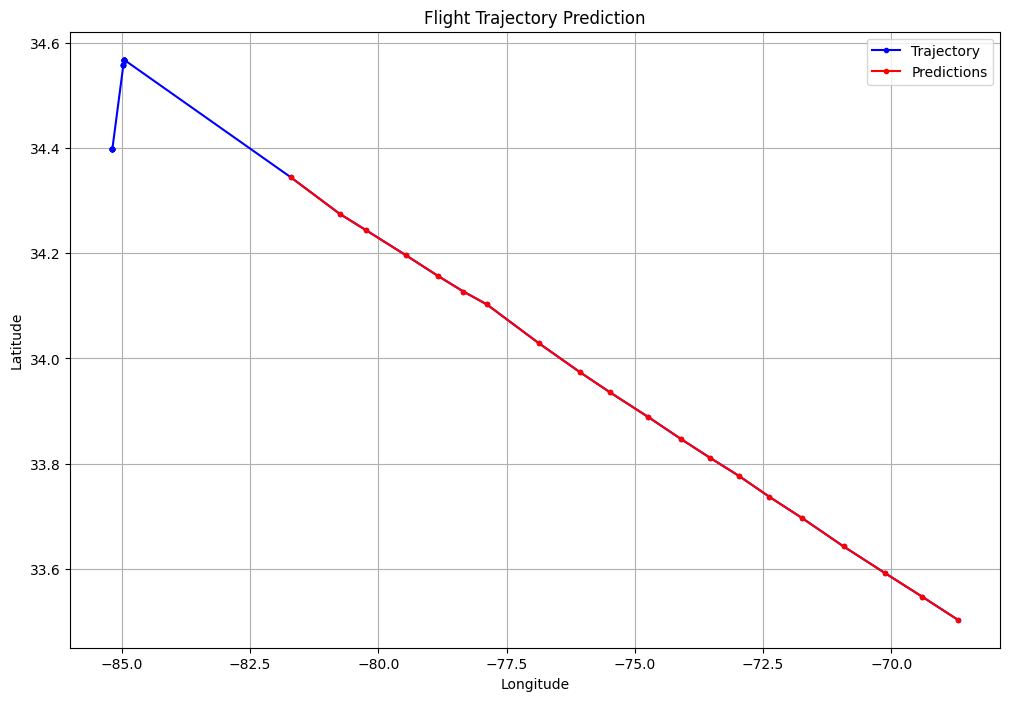

In [17]:

# Optionally, plot the trajectory
plt.figure(figsize=(12, 8))
plt.plot(full_sequence[:, 0], full_sequence[:, 1], 'b.-', label='Trajectory')
plt.plot(predictions[:, 0], predictions[:, 1], 'r.-', label='Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flight Trajectory Prediction')
plt.legend()
plt.grid(True)
plt.show()